<a href="https://colab.research.google.com/github/sdsc-bw/MCXAI/blob/main/explain_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explain a Model of Covertype Dataset

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image, ImageDraw, ImageFont

In [2]:
from explainer import Explainer
import util

## Load and Prepare Dataset

We use the [keras mnist dataset](https://keras.io/examples/vision/mnist_convnet/). The code for the dataset preparation and modelling are based on this website.

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Train Model

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='valid', data_format = 'channels_last'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='valid', data_format = 'channels_last'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [5]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 13s 31ms/step - loss: 0.3593 - accuracy: 0.8898 - val_loss: 0.0867 - val_accuracy: 0.9773
Epoch 2/15
422/422 [==============================] - 13s 30ms/step - loss: 0.1169 - accuracy: 0.9641 - val_loss: 0.0592 - val_accuracy: 0.9843
Epoch 3/15
422/422 [==============================] - 13s 30ms/step - loss: 0.0878 - accuracy: 0.9725 - val_loss: 0.0486 - val_accuracy: 0.9862
Epoch 4/15
422/422 [==============================] - 13s 30ms/step - loss: 0.0736 - accuracy: 0.9776 - val_loss: 0.0420 - val_accuracy: 0.9885
Epoch 5/15
422/422 [==============================] - 12s 29ms/step - loss: 0.0660 - accuracy: 0.9792 - val_loss: 0.0379 - val_accuracy: 0.9902
Epoch 6/15
422/422 [==============================] - 12s 29ms/step - loss: 0.0577 - accuracy: 0.9812 - val_loss: 0.0391 - val_accuracy: 0.9888
Epoch 7/15
422/422 [==============================] - 12s 29ms/step - loss: 0.0525 - accuracy: 0.9835 - val_loss: 0.0384 - val_accuracy:

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.027469519525766373
Test accuracy: 0.9900000095367432


## Pick a Sample for Explanation

In [7]:
sample = x_test[0].squeeze()
target_label = np.argmax(y_test[0])

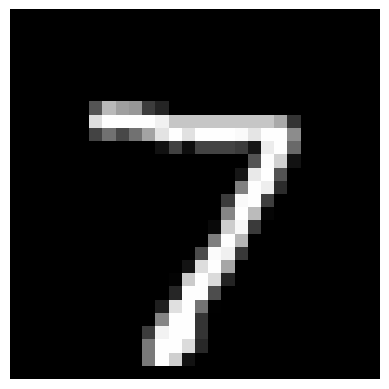

In [8]:
plt.imshow(sample, cmap='gray')
plt.axis("off")
plt.show()

In [9]:
target_label

7

In [10]:
model.predict(np.expand_dims(sample.reshape(28, 28, 1), axis=0))

array([[3.9499382e-09, 6.5734279e-11, 8.3598006e-06, 2.8119864e-06,
        1.0289834e-12, 2.9822167e-10, 3.4116981e-16, 9.9998820e-01,
        2.0498392e-08, 6.3432844e-07]], dtype=float32)

## Explain the Sample

In [11]:
kernel_size = 3

In [12]:
def predict(data):
    if data.shape == (28, 28):
        return model.predict(np.expand_dims(data.reshape(28, 28, 1), axis=0))
    else:
        return model.predict(data.reshape(-1, 28, 28, 1))

In [13]:
explainer = Explainer(sample, predict, target_label, hide_value=0, kernel_size=3, max_depth=20, max_episodes=10000)

In [14]:
explainer.explain()

2021-11-02 12:54:32,591 - agent - INFO - XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-11-02 12:54:32,592 - agent - INFO - Episode:	0
2021-11-02 12:54:32,593 - agent - INFO - XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-11-02 13:00:12,968 - agent - INFO - XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-11-02 13:00:12,968 - agent - INFO - Episode:	1000
2021-11-02 13:00:12,969 - agent - INFO - XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-11-02 13:05:26,785 - agent - INFO - XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-11-02 13:05:26,786 - agent - INFO - Episode:	2000
2021-11-02 13:05:26,786 - agent - INFO - XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-11-02 13:10:56,499 - agent - INFO - XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-11-02 13:10:56,500 - agent - INFO - Episode:	3000

In [15]:
ranks_1, ranks_2 = explainer.get_explanation()

Now the features are ranked by their importance, if the explainer was able to change the prediction (change the class with the highest probability). The lower the rank of the feature, the more important is this feature.

In [16]:
def plot_masked(ranks, sample, scale, ksize, offset=0):
    img = Image.fromarray(np.uint8(sample*255))
    img = img.resize((28 * scale, 28 * scale), resample=Image.BOX)
    img = img.convert('RGBA')
    
    t_img = Image.new('RGBA', (28 * scale, 28 * scale), (255, 0, 0, 0))
    fnt = ImageFont.truetype('/Library/Fonts/arial.ttf', (scale - offset) * ksize)
    d_img = ImageDraw.Draw(img)
    fillcolor = "white"
    shadowcolor = "black"
    
    for x in range(0, 28, ksize):
        for y in range(0, 28, ksize):
            number = ranks[x][y]
            if number != 0:
                text = str(int(number))
                xt = x * scale
                yt = y * scale
                
                # thin border
                d_img.text((yt-3, xt), text, font=fnt, fill=shadowcolor)
                d_img.text((yt+3, xt), text, font=fnt, fill=shadowcolor)
                d_img.text((yt, xt-3), text, font=fnt, fill=shadowcolor)
                d_img.text((yt, xt+3), text, font=fnt, fill=shadowcolor)

                # thicker border
                d_img.text((yt-3, xt-3), text, font=fnt, fill=shadowcolor)
                d_img.text((yt+3, xt-3), text, font=fnt, fill=shadowcolor)
                d_img.text((yt-3, xt+3), text, font=fnt, fill=shadowcolor)
                d_img.text((yt+3, xt+3), text, font=fnt, fill=shadowcolor)
                
                d_img.text((yt, xt), text, font=fnt, fill=fillcolor)

    for x in range(0, img.width, ksize * scale):
        line = ((x, 0), (x, img.height))
        d_img.line(line, fill=(255, 0, 0))
        
    for y in range(0, img.height, ksize * scale):
        line = ((0, y), (img.width, y))
        d_img.line(line, fill=(255, 0, 0))
    
    img.paste(t_img, (0, 0), t_img)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

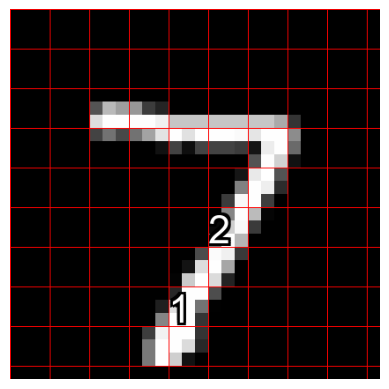

In [17]:
plot_masked(ranks_1, sample, 15, kernel_size)

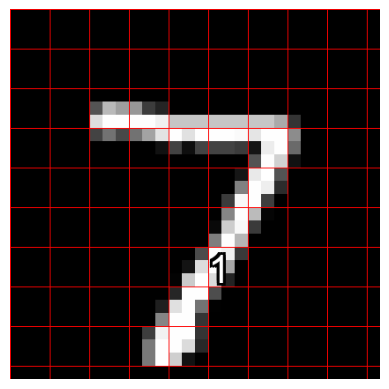

In [18]:
plot_masked(ranks_2, sample, 15, kernel_size)